<h1>Temperature data analysis</h1>

In [2]:
import pandas as pd
import numpy as np 
import plotly.express as px

In [3]:
# Air temperature in celsius
path_temp_data_c = "C:/pale-blue-dot-challenge/data/g4.areaAvgTimeSeries.AIRX3STD_006_Temperature_A.500hPa.20020831-20160925.175W_60S_172E_86N.csv"
temp_data_c = pd.read_csv(path_temp_data_c, skiprows=9,  usecols=[0,1], names=['Time','Air Temperature (C)'])

# Air temperature in kelvin
path_temp_data_k = "C:/pale-blue-dot-challenge/data/g4.areaAvgTimeSeries.AIRX3STD_006_Temperature_A.500hPa.20020801-20160925.175W_60S_172E_86N_K.csv"
temp_data_k = pd.read_csv(path_temp_data_k, skiprows=9,  usecols=[0,1], names=['Time','Air Temperature (K)'])

In [4]:
temp_data_c.head()

,Time,Air Temperature (C)
0,2002-08-31,-12.705908
1,2002-09-01,-12.676642
2,2002-09-02,-12.611639
3,2002-09-03,-12.633154
4,2002-09-04,-12.806067


In [5]:
temp_data_c.tail()

,Time,Air Temperature (C)
5089,2016-09-20,-12.900000
5090,2016-09-21,-12.909765
5091,2016-09-22,-13.080816
5092,2016-09-23,-13.035253
5093,2016-09-24,-11.984503


In [6]:
temp_data_c.shape

(5094, 2)

In [7]:
px.line(temp_data_c, x="Time", y="Air Temperature (C)")

In [10]:
px.line(temp_data_k, x="Time", y="Air Temperature (K)")

<h4>Accessing MODIS temperature data with the Planetary Computer STAC API</h4>

In [2]:
import odc.stac
import planetary_computer
import pystac_client
import rich.table

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [4]:
latitude = 43.6
longitude = -116.2
buffer = 1
bbox = [longitude - buffer, latitude - buffer, longitude + buffer, latitude + buffer]

year = "2021"
months = {
    "March": "03",
    "June": "06",
    "September": "09",
    "December": "12",
}
items = dict()

# Fetch the collection of interest and print available items
for name, number in months.items():
    datetime = f"{year}-{number}"
    search = catalog.search(
        collections=["modis-11A1-061"],
        bbox=bbox,
        datetime=datetime,
    )
    items[name] = search.item_collection()[0]

In [7]:
t = rich.table.Table("Key", "Title")
for key, asset in items["March"].assets.items():
    t.add_row(key, asset.title)
t

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key              ┃ Title                                                               ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ hdf              │ Source data containing all bands                                    │
│ QC_Day           │ Quality control for daytime LST and emissivity                      │
│ Emis_31          │ Band 31 emissivity                                                  │
│ Emis_32          │ Band 32 emissivity                                                  │
│ QC_Night         │ Quality control for nighttime LST and emissivity                    │
│ metadata         │ Federal Geographic Data Committee (FGDC) Metadata                   │
│ LST_Day_1km      │ Daily daytime 1km grid Land-surface Temperature                     │
│ Clear_day_cov    │ Day clear-sky coverage                                              │
│ Day_view_angl    │ View zenith angle of daytime Landsurface Temperature                │
│ Day_view_time    │ (local solar) Time of daytime Land-surface Temperature observation  │
│ LST_Night_1km    │ Daily nighttime 1km grid Land-surface Temperature                   │
│ Clear_night_cov  │ Night clear-sky coverage                                            │
│ Night_view_angl  │ View zenith angle of nighttime Landsurface Temperature              │
│ Night_view_time  │ (local solar) Time of nighttime Landsurface Temperature observation │
│ tilejson         │ TileJSON with default rendering                                     │
│ rendered_preview │ Rendered preview                                                    │
└──────────────────┴─────────────────────────────────────────────────────────────────────┘

In [5]:
data = odc.stac.load(
    items.values(),
    crs="EPSG:3857",
    bands="LST_Day_1km",
    resolution=500,
    bbox=bbox,
)

raster = items["March"].assets["LST_Day_1km"].extra_fields["raster:bands"]
data = data["LST_Day_1km"] * raster[0]["scale"]
data

<xarray.DataArray 'LST_Day_1km' (time: 4, y: 616, x: 446)>
array([[[277.98, 280.14, 280.14, ..., 276.98, 278.24, 278.24],
        [277.98, 277.98, 280.14, ..., 276.98, 276.98, 278.24],
        [277.78, 277.98, 277.98, ..., 274.68, 276.98, 276.98],
        ...,
        [301.66, 301.66, 300.78, ..., 302.42, 302.42, 303.1 ],
        [300.3 , 301.66, 301.66, ..., 303.86, 302.42, 302.42],
        [300.26, 300.26, 300.66, ..., 302.84, 302.84, 302.84]],

       [[310.84, 311.98, 311.98, ...,   0.  ,   0.  ,   0.  ],
        [310.84, 310.84, 311.98, ...,   0.  ,   0.  ,   0.  ],
        [309.56, 310.84, 310.84, ..., 300.98,   0.  ,   0.  ],
        ...,
        [322.68, 322.68, 323.64, ..., 328.64, 328.64, 328.64],
        [323.3 , 322.68, 322.68, ..., 328.52, 328.64, 328.64],
        [320.56, 320.56, 322.6 , ..., 327.88, 327.88, 327.88]],

       [[294.5 , 295.36, 295.36, ..., 296.5 , 299.5 , 299.5 ],
        [294.5 , 294.5 , 295.36, ..., 296.5 , 296.5 , 299.5 ],
        [293.1 , 294.5 , 294.5 , ..., 293.08, 296.5 , 296.5 ],
        ...,
        [303.96, 303.96, 304.62, ..., 307.92, 307.92, 308.26],
        [302.38, 303.96, 303.96, ..., 308.94, 307.92, 307.92],
        [303.16, 303.16, 305.38, ..., 308.78, 308.78, 308.78]],

       [[260.72, 261.08, 261.08, ...,   0.  ,   0.  ,   0.  ],
        [260.72, 260.72, 261.08, ...,   0.  ,   0.  ,   0.  ],
        [260.18, 260.72, 260.72, ...,   0.  ,   0.  ,   0.  ],
        ...,
        [  0.  ,   0.  ,   0.  , ..., 264.72, 264.72, 264.86],
        [  0.  ,   0.  ,   0.  , ..., 264.7 , 264.72, 264.72],
        [  0.  ,   0.  ,   0.  , ..., 265.74, 265.74, 265.74]]])
Coordinates:
  * y            (y) float64 5.559e+06 5.558e+06 ... 5.252e+06 5.251e+06
  * x            (x) float64 -1.305e+07 -1.305e+07 ... -1.282e+07 -1.282e+07
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2021-03-31 2021-06-30 ... 2021-12-31

C:\Users\marti\AppData\Local\Temp\ipykernel_8488\260690661.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax, datetime in zip(g.axes.flat, datetimes):


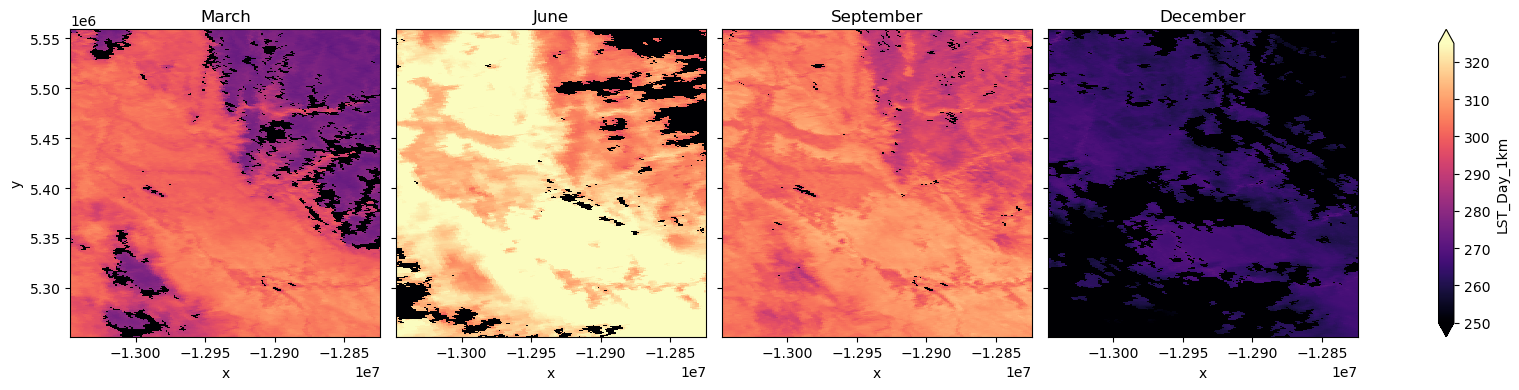

In [6]:
g = data.plot.imshow(cmap="magma", col="time", vmin=250, vmax=325, size=4)
datetimes = data.time.to_pandas().dt.strftime("%B")

for ax, datetime in zip(g.axes.flat, datetimes):
    ax.set_title(datetime)

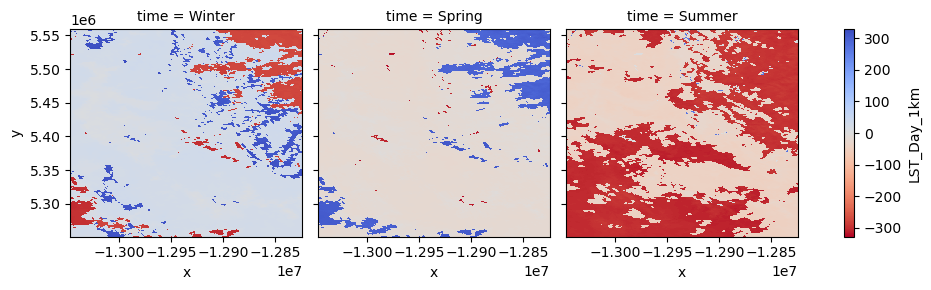

In [8]:
change = data.diff(dim="time").assign_coords(time=["Winter", "Spring", "Summer"])
change.plot.imshow(cmap="coolwarm_r", col="time");